## Load Spotify API

In [89]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import json

In [90]:
with open('./config.json') as f:
    config = json.load(f)
client_id = config['client_id']
client_secret = config['client_secret']
redirect_uri='https://www.google.com/'

In [91]:
username = config['username']
client_creds_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
scope = "user-library-read playlist-read-private"
try:
    token = util.prompt_for_user_token(username, scope, client_id=client_id, 
                                       client_secret=client_secret, redirect_uri=redirect_uri)
    sp = spotipy.Spotify(auth=token)
except:
    print(f'token is not accessible for {username}')

## Grab Data from Spotify API

In [92]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
playlist_dict = {
    "Get Turnt": "37i9dQZF1DWY4xHQp97fN6",
    "Classical Essentials": "37i9dQZF1DWWEJlAGA9gs0", #37i9dQZF1DXaXB8fQg7xif
    "Rock Save the Queen" : "37i9dQZF1DXcDnIr0iKAG8",
    "Coffee Table Jazz" : "37i9dQZF1DWVqfgj8NZEp1"
}
spotify_username = 'Spotify'

In [94]:
# Load the playlists into objects
playlists = [sp.user_playlist(spotify_username, playlist_id=v) for _, v in playlist_dict.items()]

In [95]:
def extract_playlist_info(playlists):
    df_playlists = []
    for playlist in playlists:
        playlist_items = playlist['tracks']['items']
        df_playlist = pd.DataFrame(columns=('song_id', 'song_name', 'song_artist'))
        for item in playlist_items:
            track = item['track']
            df_playlist = df_playlist.append(
                {
                    'song_id': track['id'],
                    'song_name': track['name'],
                    'song_artist': track['artists'][0]['name']
                },
                ignore_index=True
            )
        df_playlists.append(df_playlist)
    return df_playlists

In [96]:
def extract_audio_features(df_playlists):
    df_features_list = []
    columns = ['song_name', 'danceability', 'energy', 'key', 'loudness', 'mode', 
            'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']
    for df_playlist in df_playlists:
        song_ids = list(df_playlist['song_id'])
        df_audio_features = pd.DataFrame(data=sp.audio_features(tracks=song_ids))
        
        df_features = df_audio_features[columns[1:]].join(df_playlist['song_name'])
        df_features_list.append(df_features[columns]) # put columns inside to make sure song_name 
                                                      #is the first column.
    return df_features_list

In [98]:
df_playlists = extract_playlist_info(playlists)
df_features_list = extract_audio_features(df_playlists)
pprint(df_features_list[0].loc[4])
print()
pprint(df_features_list[2].loc[8])

song_name           Pure Water (with Migos)
danceability                           0.68
energy                                0.559
key                                       0
loudness                             -5.545
mode                                      1
speechiness                           0.129
acousticness                          0.172
instrumentalness                          0
valence                               0.137
tempo                               202.006
Name: 4, dtype: object

song_name            Silence
danceability           0.448
energy                 0.823
key                        6
loudness              -3.968
mode                       0
speechiness            0.069
acousticness        0.000153
instrumentalness           0
valence                0.298
tempo                139.964
Name: 8, dtype: object


## Setting up Training Data

In [12]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [13]:
def convert_df_to_array(df):
    converted_list = []
    for _, row in df.iterrows():
        converted_list.append(np.array(list(row[1:])))  # use 1: to avoid adding in song name
    return np.asarray(converted_list)

In [124]:
def create_X_data(df_features_list):
    X = []
    for df_features in df_features_list:
        converted_array = convert_df_to_array(df_features)
        for item in converted_array:
            X.append(item)
    return np.asarray(X)

In [125]:
def create_y_data():
    y = np.array([])
    for i in range(0, 4):
        y = np.append(y, np.ones(shape=(100, 1)) * i)
    return y

In [126]:
X = create_X_data(df_features_list) 
X.shape

(400, 10)

In [127]:
y = to_categorical(create_y_data())
y.shape

(400, 4)

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) # data set small
                                                                                          # so smaller test size
X_train.shape, y_train.shape

((360, 10), (360, 4))

## Create Model

In [70]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix

In [74]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Model V1

In [45]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=10))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [47]:
sgd = SGD()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=90, epochs=30)

Epoch 1/30
360/360 [==============================] - 0s 792us/step - loss: 1.3432 - acc: 0.3778
Epoch 2/30
360/360 [==============================] - 0s 29us/step - loss: 1.3899 - acc: 0.3556
Epoch 3/30
360/360 [==============================] - 0s 49us/step - loss: 1.3250 - acc: 0.3917
Epoch 4/30
360/360 [==============================] - 0s 55us/step - loss: 1.3488 - acc: 0.3833
Epoch 5/30
360/360 [==============================] - 0s 46us/step - loss: 1.3153 - acc: 0.3833
Epoch 6/30
360/360 [==============================] - 0s 42us/step - loss: 1.2965 - acc: 0.4083
Epoch 7/30
360/360 [==============================] - 0s 52us/step - loss: 1.3041 - acc: 0.3861
Epoch 8/30
360/360 [==============================] - 0s 35us/step - loss: 1.3669 - acc: 0.3917
Epoch 9/30
360/360 [==============================] - 0s 59us/step - loss: 1.3670 - acc: 0.3889
Epoch 10/30
360/360 [==============================] - 0s 33us/step - loss: 1.3550 - acc: 0.3667
Epoch 11/30
360/360 [=================

In [76]:
model.evaluate(X_test, y_test, batch_size=90)

40/40 [==============================] - 0s 968us/step


[1.2115564346313477, 0.44999998807907104]

In [66]:
y_pred = model.predict(X_test)
y_pred

array([[ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.25713977,  0.23461829,  0.25440991,  0.25383201],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.00268208,  0.7707898 ,  0.00245204,  0.22407609],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.20810698,  0.31221068,  0.18708426,  0.29259804],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.25212696,  0.24187399,  0.24700922,  0.25898978],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.26248315,  0.

Confusion matrix, without normalization
[[ 1  0 11  0]
 [ 1  6  1  1]
 [ 0  0 11  0]
 [ 1  6  1  0]]


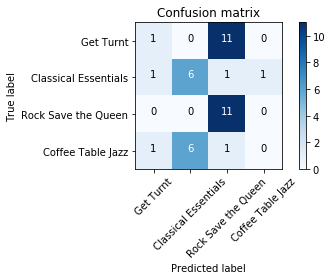

In [81]:
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=playlist_dict, normalize=False,
                      title='Confusion matrix')
plt.show()

Looking at this confusion matrix, I notice 3 things.
1. Testing dataset is very small. I need to expand my total data set
2. Coffee table jazz and Get Turnt are not being classfied correctly. Exploration is needed to see why
3. Rock save the queen is doing quite well. Exploration is needed to see why.

### Model V2

In [178]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=10))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))

In [179]:
sgd = SGD()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model.fit(X_train, y_train, batch_size=60, epochs=150)
model.evaluate(X_test, y_test, batch_size=60)

Epoch 1/150
300/300 [==============================] - 0s 54us/step - loss: 0.7365 - acc: 0.5700
Epoch 2/150
300/300 [==============================] - 0s 46us/step - loss: 0.7616 - acc: 0.5133
Epoch 3/150
300/300 [==============================] - 0s 47us/step - loss: 0.7417 - acc: 0.5700
Epoch 4/150
300/300 [==============================] - 0s 54us/step - loss: 0.7213 - acc: 0.5667
Epoch 5/150
300/300 [==============================] - 0s 59us/step - loss: 0.7377 - acc: 0.5700
Epoch 6/150
300/300 [==============================] - 0s 59us/step - loss: 0.7392 - acc: 0.6000
Epoch 7/150
300/300 [==============================] - 0s 61us/step - loss: 0.7416 - acc: 0.5533
Epoch 8/150
300/300 [==============================] - 0s 71us/step - loss: 0.7407 - acc: 0.5800
Epoch 9/150
300/300 [==============================] - 0s 61us/step - loss: 0.8421 - acc: 0.5467
Epoch 10/150
300/300 [==============================] - 0s 69us/step - loss: 0.8740 - acc: 0.5367
Epoch 11/150
300/300 [=======

300/300 [==============================] - 0s 46us/step - loss: 0.8142 - acc: 0.5233
Epoch 85/150
300/300 [==============================] - 0s 48us/step - loss: 0.8641 - acc: 0.5200
Epoch 86/150
300/300 [==============================] - 0s 67us/step - loss: 0.7512 - acc: 0.5300
Epoch 87/150
300/300 [==============================] - 0s 44us/step - loss: 0.8000 - acc: 0.5167
Epoch 88/150
300/300 [==============================] - 0s 46us/step - loss: 0.7428 - acc: 0.5533
Epoch 89/150
300/300 [==============================] - 0s 75us/step - loss: 0.7692 - acc: 0.5400
Epoch 90/150
300/300 [==============================] - 0s 73us/step - loss: 0.7554 - acc: 0.5467
Epoch 91/150
300/300 [==============================] - 0s 61us/step - loss: 0.7488 - acc: 0.5100
Epoch 92/150
300/300 [==============================] - 0s 70us/step - loss: 0.7359 - acc: 0.5967
Epoch 93/150
300/300 [==============================] - 0s 72us/step - loss: 0.7476 - acc: 0.5800
Epoch 94/150
300/300 [===========

[0.80615235567092891, 0.64000000953674319]

Confusion matrix, without normalization
[[ 6  0  5  1]
 [ 0  3  0  6]
 [ 0  0 11  0]
 [ 0  1  0  7]]


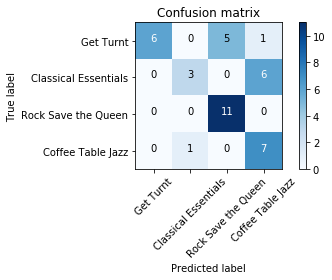

In [165]:
y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=playlist_dict, normalize=False,
                      title='Confusion matrix')
plt.show()

Changing the amount of neurons in the first layer, drop out rate, batch size and epochs makes quite a big difference. The new model has an accuracy of almost 70%, a significant improvement from the first version. 
I feel that data exploration is still needed. Maybe I need to change my dataset and eliminate some redundant columns.
Data Exploration will help me indicate what I columns would be most unique.

## Exploration